<a href="https://colab.research.google.com/github/Winkielek/gflownet/blob/master/notebooks/trajectories.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Clone gflownet lib
!rm -rf gflownet
!git clone https://github.com/Winkielek/gflownet.git

# Freeze torch version
!pip install torch==2.1.0+cu121 -f https://download.pytorch.org/whl/torch_stable.html

# Install torch geometric
!pip install torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.1.0+cu121.html
!pip install torch-geometric scipy==1.8 deepchem

# Install gflownet lib
!pip install -e ./gflownet

Cloning into 'gflownet'...
remote: Enumerating objects: 1400, done.
remote: Counting objects: 100% (524/524), done.
remote: Compressing objects: 100% (180/180), done.
remote: Total 1400 (delta 402), reused 368 (delta 343), pack-reused 876
Receiving objects: 100% (1400/1400), 13.74 MiB | 24.34 MiB/s, done.
Resolving deltas: 100% (779/779), done.
Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 47.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.2/693.2 kB 45.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 13.0 MB/s eta 0:00:00
  Attempting uninstall: scipy
    F

In [1]:
import os
import shutil
import socket
from typing import Callable, Dict, List, Tuple, Union

import numpy as np
import torch
import torch.nn as nn
import torch_geometric.data as gd
from rdkit import Chem
from rdkit.Chem.rdchem import Mol as RDMol
from torch import Tensor
from torch.utils.data import Dataset

from gflownet.config import Config
from gflownet.envs.frag_mol_env import FragMolBuildingEnvContext, Graph
from gflownet.models import bengio2021flow
from gflownet.online_trainer import StandardOnlineTrainer
from gflownet.trainer import FlatRewards, GFNTask, RewardScalar
from gflownet.utils.conditioning import TemperatureConditional

import matplotlib.pyplot as plt
import networkx as nx

In [2]:
from gflownet.tasks.seh_frag import SEHFragTrainer

In [3]:
hps = {
    "log_dir": "./logs/debug_run_seh_frag_pb",
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "overwrite_existing_exp": True,
    "num_training_steps": 500,
    "num_workers": 2,
    "opt": {
        "lr_decay": 20000,
    },
    "algo": {"sampling_tau": 0.99, "offline_ratio": 0.0},
    "cond": {
        "temperature": {
            "sample_dist": "uniform",
            "dist_params": [0, 64.0],
        }
    },
}
if os.path.exists(hps["log_dir"]):
    if hps["overwrite_existing_exp"]:
        shutil.rmtree(hps["log_dir"])
    else:
        raise ValueError(f"Log dir {hps['log_dir']} already exists. Set overwrite_existing_exp=True to delete it.")
os.makedirs(hps["log_dir"])

trial = SEHFragTrainer(hps)
trial.print_every = 100
# trial.run()



Hyperparameters:

log_dir: ./logs/debug_run_seh_frag_pb
device: cuda
seed: 0
validate_every: 1000
checkpoint_every: null
print_every: 100
start_at_step: 0
num_final_gen_steps: null
num_training_steps: 500
num_workers: 2
hostname: 4b4faad44736
pickle_mp_messages: false
git_hash: 2b83c36
overwrite_existing_exp: true
algo:
  method: TB
  global_batch_size: 64
  max_len: 128
  max_nodes: 9
  max_edges: 128
  illegal_action_logreward: -75.0
  offline_ratio: 0.0
  valid_offline_ratio: 0.0
  train_random_action_prob: 0.0
  valid_random_action_prob: 0.0
  valid_sample_cond_info: true
  sampling_tau: 0.99
  tb:
    bootstrap_own_reward: false
    epsilon: null
    reward_loss_multiplier: 1.0
    variant: TB
    do_correct_idempotent: false
    do_parameterize_p_b: false
    do_sample_p_b: true
    do_length_normalize: false
    subtb_max_len: 128
    Z_learning_rate: 0.001
    Z_lr_decay: 50000.0
    cum_subtb: true
  moql:
    gamma: 1.0
    num_omega_samples: 32
    num_objectives: 2
    la

In [4]:
PATH = "./model"

In [5]:
# torch.save(trial.model.state_dict(), PATH)

In [6]:
model = trial.model
model.load_state_dict(torch.load(PATH))
model = model.to("cuda")

In [7]:
n = 1000
batch_size = 100
num_gen = 0

traj = []
rew = []

while num_gen<n:

    pred = trial.algo.graph_sampler.sample_from_model(
    model,
    batch_size,
    trial.task.sample_conditional_information(batch_size,None)["encoding"].to("cuda"),
    "cuda"
    )

    # Store trajectories
    for p in pred:
        traj.append(p["traj"])
    # Store rewards
    mols = [trial.ctx.graph_to_mol(p["result"])for p in pred]
    rewards = trial.task.compute_flat_rewards(mols)
    rewards = rewards[0].numpy().reshape(-1).tolist()
    rew += rewards
    num_gen += batch_size

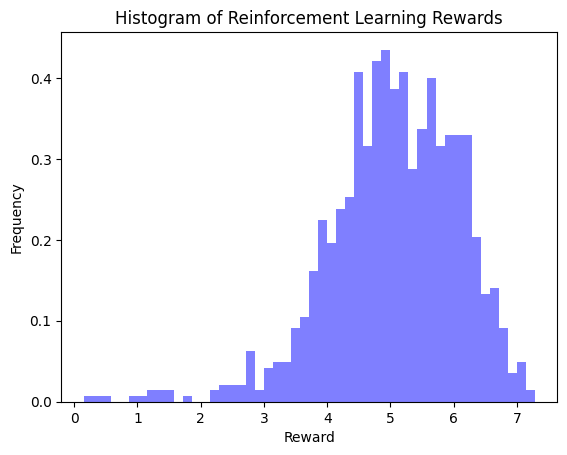

In [8]:
# Create a histogram
plt.hist([x*8 for x in rew], bins=50, density=True, alpha=0.5, color='blue')

# Add labels and title
plt.xlabel('Reward')
plt.ylabel('Frequency')
plt.title('Histogram of Reinforcement Learning Rewards')

# Show the plot
plt.show()

In [9]:
traj[0]

[(<[], [], []>, <GraphActionType.AddNode, 0, 7>),
 (<[0], [], [7]>, <GraphActionType.AddNode, 0, 56>),
 (<[0, 1], [(0, 1)], [7, 56]>, <GraphActionType.AddNode, 0, 67>),
 (<[0, 1, 2], [(0, 1), (0, 2)], [7, 56, 67]>,
  <GraphActionType.SetEdgeAttr, 0, 2, dst_attach, 1>),
 (<[0, 1, 2], [(0, 1), (0, 2)], [7, 56, 67]>,
  <GraphActionType.AddNode, 2, 70>),
 (<[0, 1, 2, 3], [(0, 1), (0, 2), (2, 3)], [7, 56, 67, 70]>,
  <GraphActionType.AddNode, 3, 7>),
 (<[0, 1, 2, 3, 4], [(0, 1), (0, 2), (2, 3), (3, 4)], [7, 56, 67, 70, 7]>,
  <GraphActionType.AddNode, 4, 71>),
 (<[0, 1, 2, 3, 4, 5], [(0, 1), (0, 2), (2, 3), (3, 4), (4, 5)], [7, 56, 67, 70, 7, 71]>,
  <GraphActionType.AddNode, 0, 31>),
 (<[0, 1, 2, 3, 4, 5, 6], [(0, 1), (0, 2), (0, 6), (2, 3), (3, 4), (4, 5)], [7, 56, 67, 70, 7, 71, 31]>,
  <GraphActionType.AddNode, 6, 7>),
 (<[0, 1, 2, 3, 4, 5, 6, 7], [(0, 1), (0, 2), (0, 6), (2, 3), (3, 4), (4, 5), (6, 7)], [7, 56, 67, 70, 7, 71, 31, 7]>,
  <GraphActionType.AddNode, 5, 69>),
 (<[0, 1, 2, 3

In [10]:
# How does a step of trajectory look like?
traj_id = 10
state = 4
print(traj[traj_id][state])
print(f"Current graph: {traj[traj_id][state][0]}")
cur_action = traj[traj_id][state][1]
print(f"Current action: {cur_action}")
print(f"Action source: {cur_action.source}")
print(f"Action target: {cur_action.target}")
print(f"Action value: {cur_action.value}")

(<[0, 1, 2, 3], [(0, 1), (0, 2), (2, 3)], [7, 7, 7, 30]>, <GraphActionType.AddNode, 1, 65>)
Current graph: <[0, 1, 2, 3], [(0, 1), (0, 2), (2, 3)], [7, 7, 7, 30]>
Current action: <GraphActionType.AddNode, 1, 65>
Action source: 1
Action target: None
Action value: 65


C1CCCCC1
C1CCCCC1
C1CCCCC1
CNC=O
Next fragment added: c1ccccc1


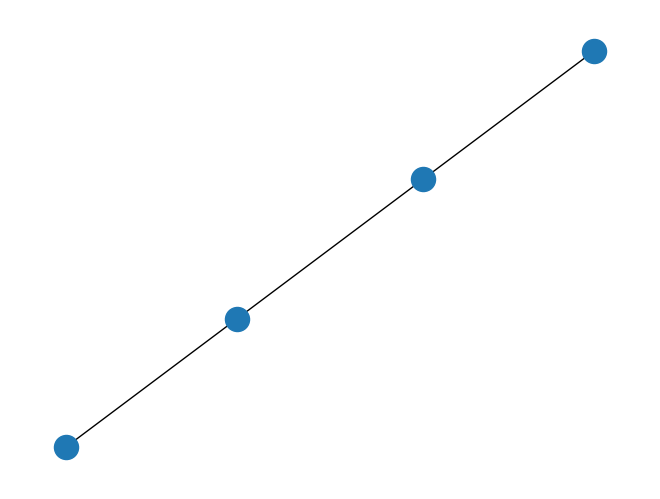

In [11]:
# How do nodes translate to fragments?
g = traj[traj_id][state][0]
for i in g.nodes:
    mol = trial.ctx.frags_mol[g.nodes[i]["v"]]
    mol_smi = trial.ctx.frags_smi[g.nodes[i]["v"]]
    print(mol_smi)
print(f"Next fragment added: {trial.ctx.frags_smi[cur_action.value]}")
nx.draw(g)

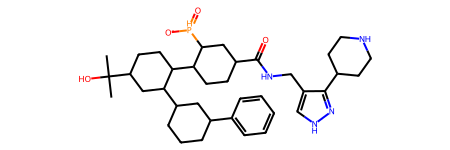

In [12]:
# Output molecule
trial.ctx.graph_to_mol(traj[traj_id][-1][0])

In [13]:
# Find min and max length of trajectories
min_len = 10**6
max_len = -1

for t in traj:
    l = len(t)
    if l>max_len:
        max_len = l
    if l<min_len:
        min_len = l
print(min_len)
print(max_len)

26
26


In [14]:
# Keep only actions from trajectories
actions = []

for t in traj:
    cur_act = []
    for step in t:
        cur_act.append(step[1])
    actions.append(cur_act)


In [15]:
actions[0]

[<GraphActionType.AddNode, 0, 7>,
 <GraphActionType.AddNode, 0, 56>,
 <GraphActionType.AddNode, 0, 67>,
 <GraphActionType.SetEdgeAttr, 0, 2, dst_attach, 1>,
 <GraphActionType.AddNode, 2, 70>,
 <GraphActionType.AddNode, 3, 7>,
 <GraphActionType.AddNode, 4, 71>,
 <GraphActionType.AddNode, 0, 31>,
 <GraphActionType.AddNode, 6, 7>,
 <GraphActionType.AddNode, 5, 69>,
 <GraphActionType.SetEdgeAttr, 3, 4, dst_attach, 1>,
 <GraphActionType.SetEdgeAttr, 5, 8, dst_attach, 2>,
 <GraphActionType.SetEdgeAttr, 0, 6, src_attach, 3>,
 <GraphActionType.SetEdgeAttr, 0, 1, dst_attach, 0>,
 <GraphActionType.SetEdgeAttr, 0, 2, src_attach, 4>,
 <GraphActionType.SetEdgeAttr, 6, 7, dst_attach, 2>,
 <GraphActionType.SetEdgeAttr, 3, 4, src_attach, 1>,
 <GraphActionType.SetEdgeAttr, 4, 5, src_attach, 5>,
 <GraphActionType.SetEdgeAttr, 0, 1, src_attach, 1>,
 <GraphActionType.SetEdgeAttr, 0, 6, dst_attach, 0>,
 <GraphActionType.SetEdgeAttr, 2, 3, src_attach, 0>,
 <GraphActionType.SetEdgeAttr, 6, 7, src_attach, 1>,

In [16]:
# Change actions representation
new_actions = []
for a in actions:
    new_act = []
    for s in a:
        new_s = []
        new_s.append(s.action.name)
        new_s.append(s.source)
        new_s.append(s.target)
        new_s.append(s.value)
        # new_s.append(s.attr)
        new_act.append(new_s)
    new_actions.append(new_act)

In [17]:
new_actions[0]

[['AddNode', 0, None, 7],
 ['AddNode', 0, None, 56],
 ['AddNode', 0, None, 67],
 ['SetEdgeAttr', 0, 2, 1],
 ['AddNode', 2, None, 70],
 ['AddNode', 3, None, 7],
 ['AddNode', 4, None, 71],
 ['AddNode', 0, None, 31],
 ['AddNode', 6, None, 7],
 ['AddNode', 5, None, 69],
 ['SetEdgeAttr', 3, 4, 1],
 ['SetEdgeAttr', 5, 8, 2],
 ['SetEdgeAttr', 0, 6, 3],
 ['SetEdgeAttr', 0, 1, 0],
 ['SetEdgeAttr', 0, 2, 4],
 ['SetEdgeAttr', 6, 7, 2],
 ['SetEdgeAttr', 3, 4, 1],
 ['SetEdgeAttr', 4, 5, 5],
 ['SetEdgeAttr', 0, 1, 1],
 ['SetEdgeAttr', 0, 6, 0],
 ['SetEdgeAttr', 2, 3, 0],
 ['SetEdgeAttr', 6, 7, 1],
 ['SetEdgeAttr', 2, 3, 0],
 ['SetEdgeAttr', 4, 5, 1],
 ['SetEdgeAttr', 5, 8, 0],
 ['Stop', None, None, None]]

In [18]:
# Numerical encoding
enc_dict = {}

action_names = set({})
action_attr = set({})

for a in new_actions:
    for s in a:
        action_names.add(s[0])
        # action_attr.add(str(s[-1]))

In [19]:
for idx, i in enumerate(action_names):
    enc_dict[i] = idx+1
# for idx, i in enumerate(action_attr):
#     enc_dict[i] = idx+1
enc_dict["None"] = -1

In [20]:
num_actions = []
for a in new_actions:
    new_a = []
    for s in a:
        new_s = []
        for i in s:
            if enc_dict.get(str(i)) is None:
                new_s.append(i)
            else:
                new_s.append(enc_dict[str(i)])
        new_a.append(new_s)
    num_actions.append(new_a)

In [21]:
num_actions[0]

[[2, 0, -1, 7],
 [2, 0, -1, 56],
 [2, 0, -1, 67],
 [1, 0, 2, 1],
 [2, 2, -1, 70],
 [2, 3, -1, 7],
 [2, 4, -1, 71],
 [2, 0, -1, 31],
 [2, 6, -1, 7],
 [2, 5, -1, 69],
 [1, 3, 4, 1],
 [1, 5, 8, 2],
 [1, 0, 6, 3],
 [1, 0, 1, 0],
 [1, 0, 2, 4],
 [1, 6, 7, 2],
 [1, 3, 4, 1],
 [1, 4, 5, 5],
 [1, 0, 1, 1],
 [1, 0, 6, 0],
 [1, 2, 3, 0],
 [1, 6, 7, 1],
 [1, 2, 3, 0],
 [1, 4, 5, 1],
 [1, 5, 8, 0],
 [3, -1, -1, -1]]

In [22]:
from keras import metrics
import keras
import tensorflow as tf
import os

In [23]:
def build_net(seq_len=26, feats=4):
    model = keras.Sequential()
    model.add(keras.layers.LSTM(32, kernel_initializer='he_uniform', batch_input_shape=(None, seq_len, feats), return_sequences=True, name='encoder_1'))
    model.add(keras.layers.LSTM(16, kernel_initializer='he_uniform', return_sequences=True, name='encoder_2'))
    model.add(keras.layers.LSTM(8, kernel_initializer='he_uniform', return_sequences=False, name='encoder_3'))
    model.add(keras.layers.RepeatVector(seq_len, name='encoder_decoder_bridge'))
    model.add(keras.layers.LSTM(8, kernel_initializer='he_uniform', return_sequences=True, name='decoder_1'))
    model.add(keras.layers.LSTM(16, kernel_initializer='he_uniform', return_sequences=True, name='decoder_2'))
    model.add(keras.layers.LSTM(32, kernel_initializer='he_uniform', return_sequences=True, name='decoder_3'))
    model.add(keras.layers.TimeDistributed(keras.layers.Dense(feats)))
    model.compile(loss="mse",optimizer='adam')
    model.build()
    print(model.summary())
    return model


In [24]:
emb_nn = build_net()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (LSTM)            (None, 26, 32)            4736      
                                                                 
 encoder_2 (LSTM)            (None, 26, 16)            3136      
                                                                 
 encoder_3 (LSTM)            (None, 8)                 800       
                                                                 
 encoder_decoder_bridge (Re  (None, 26, 8)             0         
 peatVector)                                                     
                                                                 
 decoder_1 (LSTM)            (None, 26, 8)             544       
                                                                 
 decoder_2 (LSTM)            (None, 26, 16)            1600      
                                                        

In [25]:
X, X_val = num_actions[:750], num_actions[750:]

In [26]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=1e-3, patience=5, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True)

epochs = 500
batch_size = 64
emb_nn.fit(x=X, y=X, validation_data=(X_val, X_val), epochs=epochs, batch_size=batch_size, shuffle=True, callbacks=[early_stop])


Epoch 1/500
12/12 [==============================] - 17s 258ms/step - loss: 120.8215 - val_loss: 115.7777
Epoch 2/500
12/12 [==============================] - 0s 29ms/step - loss: 116.5344 - val_loss: 112.0299
Epoch 3/500
12/12 [==============================] - 0s 29ms/step - loss: 112.8865 - val_loss: 108.5038
Epoch 4/500
12/12 [==============================] - 0s 29ms/step - loss: 109.2950 - val_loss: 104.8654
Epoch 5/500
12/12 [==============================] - 0s 26ms/step - loss: 105.5323 - val_loss: 101.1114
Epoch 6/500
12/12 [==============================] - 0s 25ms/step - loss: 101.7693 - val_loss: 97.5573
Epoch 7/500
12/12 [==============================] - 0s 26ms/step - loss: 98.3184 - val_loss: 94.3171
Epoch 8/500
12/12 [==============================] - 0s 26ms/step - loss: 95.1553 - val_loss: 91.3518
Epoch 9/500
12/12 [==============================] - 0s 26ms/step - loss: 92.2755 - val_loss: 88.7123
Epoch 10/500
12/12 [==============================] - 0s 25ms/step - 

In [27]:
from keras.models import Model
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [28]:
encoder = Model(emb_nn.input, emb_nn.layers[2].output)

In [29]:
embeddings = encoder.predict(num_actions)

32/32 [==============================] - 1s 5ms/step


In [30]:
enb_reduce = TSNE(n_components=2).fit_transform(embeddings)

In [31]:
def plt_reduce_space(x, color=rew):
    '''
    Plot Scatter with color
    '''
    plt.figure(figsize=(8, 8))
    plt.scatter(x[:, 0], x[:, 1], c=color, cmap='coolwarm')
    plt.show()

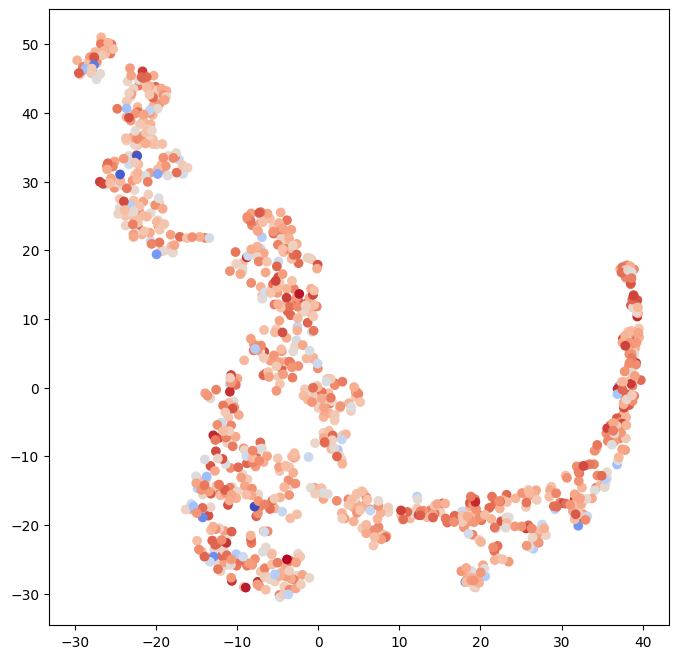

In [32]:
plt_reduce_space(enb_reduce)